# TikTok Reviews Sentiment Analysis

TikTok, kısa videolarıyla popüler bir sosyal medya platformudur. Eğlenceli içeriklerinin yanı sıra eleştiriler de almaktadır. Bu yazıda, Python kullanarak TikTok incelemelerini duygu analizi ile inceleyeceğiz.

In [31]:
# pip install nltk

In [2]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter
import plotly.express as px
import re
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Download NLTK stopwords
nltk.download('stopwords')

# Initialize stopwords and stemmer
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Set display options for pandas
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("tiktok_google_play_reviews.csv")

In [5]:
df.sample(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
133423,66c6f422-894f-4dfd-bd68-7a014a05b107,Jahidul islam,https://play-lh.googleusercontent.com/a-/ACNPE...,Good 👍👌,5,0,NaN,2022-10-04 02:51:11,NaN,NaN
413671,f7929819-c0e8-495b-8175-0f29bdf9713b,Sajith Maduranga,https://play-lh.googleusercontent.com/a/ALm5wu...,𝐍𝐢,1,0,NaN,2022-07-02 19:43:15,NaN,NaN
140819,901cc2a5-5d78-4819-ad3e-1689f8b01265,Teresa Lynne,https://play-lh.googleusercontent.com/a-/ACNPE...,Lads to much after updates please fixs,4,0,NaN,2022-09-30 21:48:43,NaN,NaN
238557,213c6f6e-e739-4d14-a953-e6275db268c7,Peter Murugu,https://play-lh.googleusercontent.com/a-/ACNPE...,Exquisite,5,0,25.7.7,2022-08-26 07:33:09,NaN,NaN
50720,f2f2c4f5-df6f-4b68-9a85-30918354e041,Tree Oflife,https://play-lh.googleusercontent.com/a/ALm5wu...,Highly entertaining..,5,0,26.8.3,2022-11-09 19:21:13,NaN,NaN


- reviewId: Yorumun benzersiz tanımlayıcısıdır.
- userName: Yorum yapan kullanıcının adını belirtir.
- userImage: Kullanıcının profil resmi için kullanılan URL'yi içerir.
- *content: Kullanıcının yorum içeriğini gösterir.
- *score: Yorumda verilen puanı (genellikle 1 ile 5 arasında).
- *thumbsUpCount: Yorumun aldığı beğeni sayısını ifade eder.
- reviewCreatedVersion: Yorumun yapıldığı uygulama sürümünü belirtir.
- at: Yorumun oluşturulma tarihini ve saatini gösterir.
- replyContent: Yorumun yanıtını (varsa) belirtir.
- repliedAt: Yorumun yanıtlandığı tarih ve saati (varsa).

In [6]:
df.shape

(460287, 10)

In [7]:
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,31
score,0
thumbsUpCount,0
reviewCreatedVersion,126334
at,0
replyContent,460027
repliedAt,460027


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460287 entries, 0 to 460286
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              460287 non-null  object
 1   userName              460287 non-null  object
 2   userImage             460287 non-null  object
 3   content               460256 non-null  object
 4   score                 460287 non-null  int64 
 5   thumbsUpCount         460287 non-null  int64 
 6   reviewCreatedVersion  333953 non-null  object
 7   at                    460287 non-null  object
 8   replyContent          260 non-null     object
 9   repliedAt             260 non-null     object
dtypes: int64(2), object(8)
memory usage: 35.1+ MB


In [9]:
df['thumbsUpCount']

,thumbsUpCount
0,0
1,0
2,0
3,0
4,0
...,...
460282,0
460283,0
460284,0
460285,0


In [10]:
df = df[["content", "score","thumbsUpCount"]]

In [11]:
df.isnull().sum()

,0
content,31
score,0
thumbsUpCount,0


In [12]:
df = df.dropna()

In [13]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # Kelime listesini oluşturma ve stopword'leri çıkarma
    text = [word for word in text.split() if word not in stopword]
    text = " ".join(text)

    # Kelimeleri köküne ayırma
    text = [stemmer.stem(word) for word in text.split()]
    text = " ".join(text)

    return text


In [14]:
# Skorların sayısını hesapla
ratings = df["score"].value_counts()
numbers = ratings.index
quantity = ratings.values

# Pasta grafiği oluşturma
pie_figure = px.pie(df,
                    values=quantity,
                    names=numbers,
                    hole=0.5,
                    title="Score Distribution")

# Çubuk grafiği oluşturma
bar_figure = px.bar(df,
                    x=numbers,
                    y=quantity,
                    title="Score Count",
                    labels={'x': 'Score', 'y': 'Count'})

# Grafikleri gösterme
pie_figure.show()
bar_figure.show()

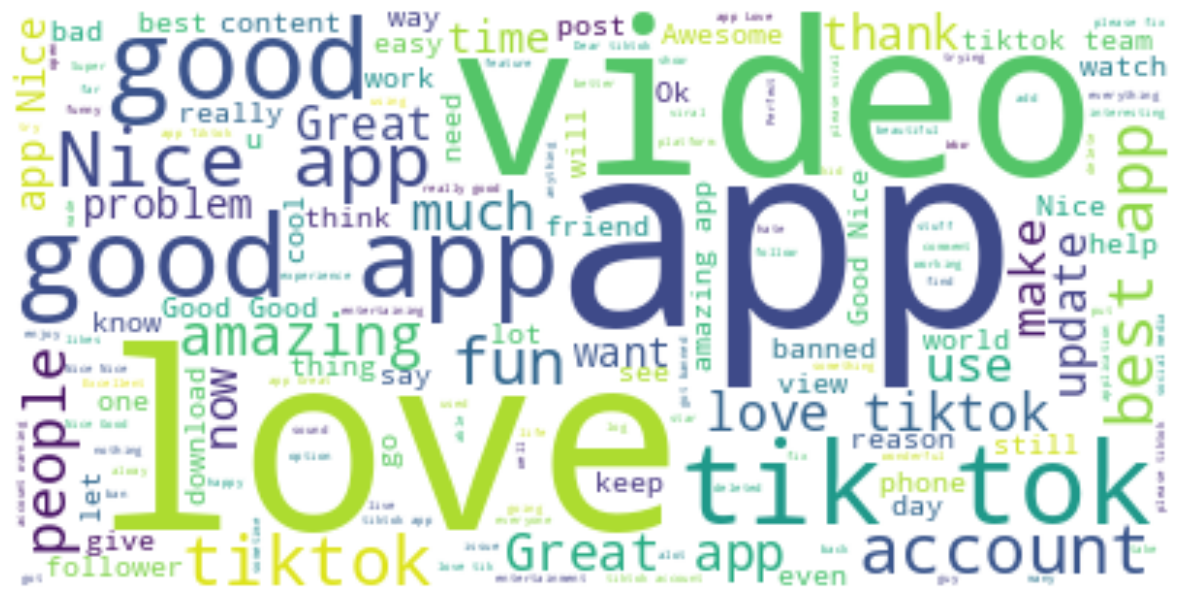

In [15]:
text = " ".join(i for i in df.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
sentiments = SentimentIntensityAnalyzer()

# Sentiment skorlarını hesaplayın
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["content"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["content"]]
df["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["content"]]

In [18]:
df = df[["content", "Positive", "Negative", "Neutral"]]

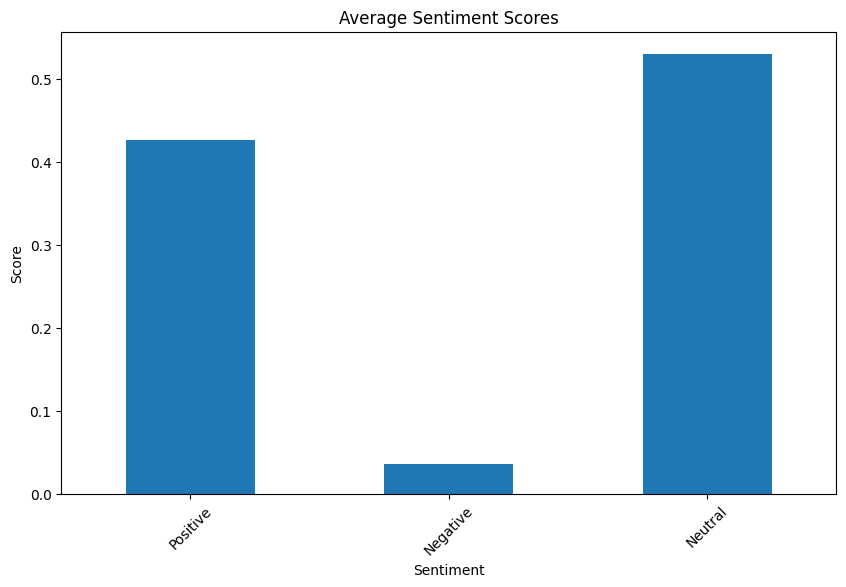

In [19]:
# Görselleştirme
df[['Positive', 'Negative', 'Neutral']].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores')
plt.ylabel('Score')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.show()

In [20]:
df.head()

,content,Positive,Negative,Neutral
0,No words,0.000,0.688,0.312
1,Great fun app so far!,0.719,0.000,0.281
2,The app would get a higher rating but I litera...,0.000,0.073,0.927
3,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,0.561,0.000,0.439
4,Pictures and record,0.000,0.000,1.000


In [21]:
positive = ' '.join([i for i in df['content'][df['Positive'] > df['Negative']]])
stopwords = set(STOPWORDS)

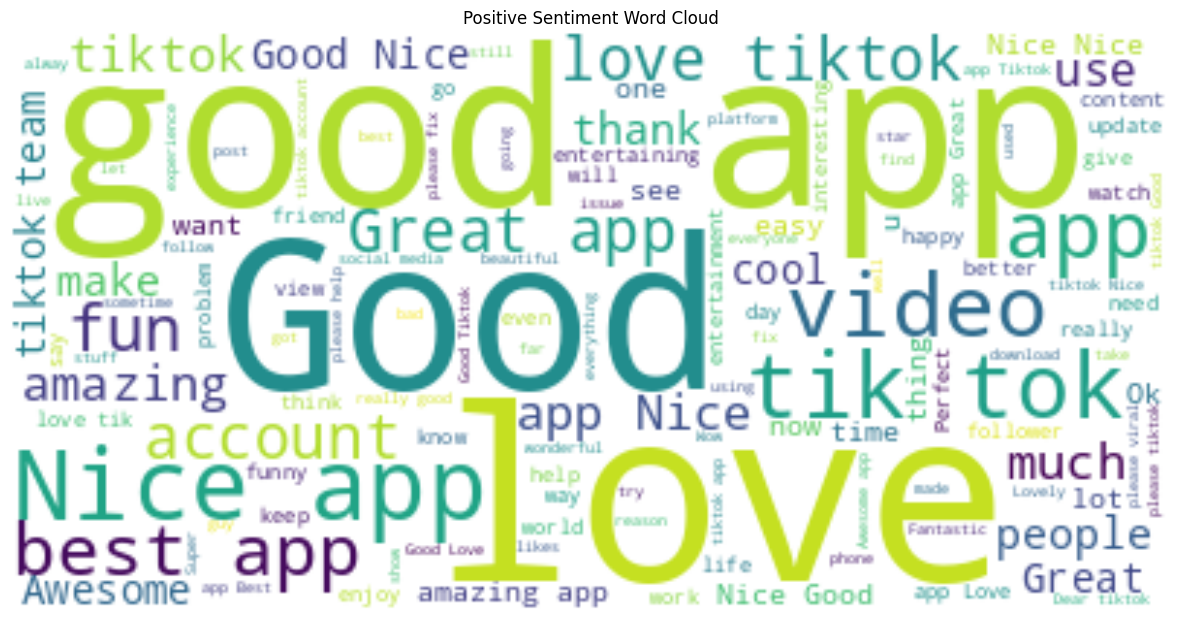

In [22]:
# Pozitif kelime bulutu
wordcloud_positive = WordCloud(stopwords=stopwords, background_color="white").generate(positive)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Sentiment Word Cloud')
plt.show()

In [23]:
negative = ' '.join([i for i in df['content'][df['Negative'] > df['Positive']]])
stopwords = set(STOPWORDS)

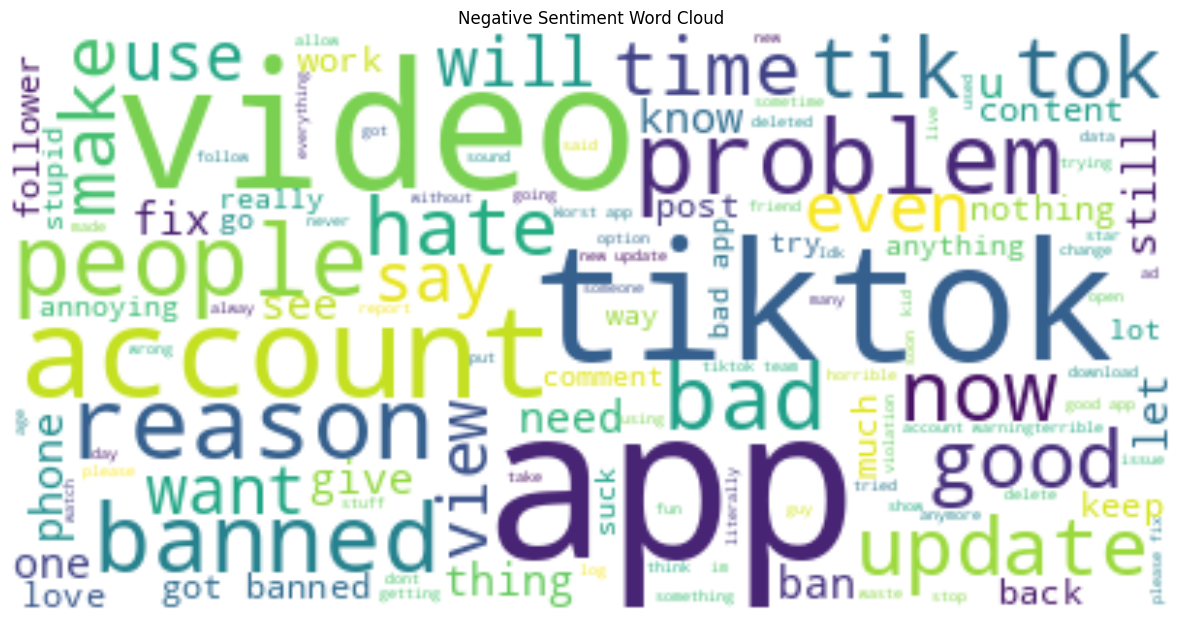

In [24]:
# Negatif kelime bulutu
wordcloud_negative = WordCloud(stopwords=stopwords, background_color="white").generate(negative)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Sentiment Word Cloud')
plt.show()

In [25]:
# Pozitif içeriklerin bigram analizini yapın
positive_bigrams = ngrams(' '.join([i for i in df['content'][df['Positive'] > df['Negative']]]).split(), 2)
positive_bigram_freq = Counter(positive_bigrams).most_common(10)  # En sık 10 bigram
print("Pozitif Bigrams:", positive_bigram_freq)

Pozitif Bigrams: [(('I', 'love'), 21861), (('this', 'app'), 13671), (('I', 'like'), 8318), (('Nice', 'app'), 8242), (('app', 'is'), 7979), (('good', 'app'), 7204), (('love', 'it'), 6929), (('my', 'account'), 6768), (('Good', 'app'), 6684), (('tik', 'tok'), 6629)]


In [26]:
# Negatif içeriklerin bigram analizini yapın
negative_bigrams = ngrams(' '.join([i for i in df['content'][df['Negative'] > df['Positive']]]).split(), 2)
negative_bigram_freq = Counter(negative_bigrams).most_common(10)  # En sık 10 bigram
print("Negatif Bigrams:", negative_bigram_freq)

Negatif Bigrams: [(('my', 'account'), 3384), (('this', 'app'), 3046), (('I', 'have'), 2415), (('for', 'no'), 2278), (('the', 'app'), 2055), (('and', 'I'), 2049), (('I', "don't"), 1999), (('no', 'reason'), 1838), (('app', 'is'), 1756), (('I', "can't"), 1700)]


In [27]:
# Tekil kelimelerin sıklığını hesaplayın
all_positive_words = ' '.join([i for i in df['content'][df['Positive'] > df['Negative']]]).split()
all_negative_words = ' '.join([i for i in df['content'][df['Negative'] > df['Positive']]]).split()

In [28]:
positive_word_freq = Counter(all_positive_words).most_common(10)
negative_word_freq = Counter(all_negative_words).most_common(10)

print("Pozitif Kelimeler:", positive_word_freq)
print("Negatif Kelimeler:", negative_word_freq)

Pozitif Kelimeler: [('app', 82461), ('I', 76371), ('and', 50062), ('it', 42951), ('is', 40474), ('to', 39158), ('the', 38905), ('Good', 35319), ('my', 33543), ('good', 32598)]
Negatif Kelimeler: [('I', 28010), ('and', 20873), ('the', 17138), ('to', 17006), ('it', 14618), ('my', 14135), ('is', 12613), ('app', 11536), ('a', 11415), ('for', 9289)]


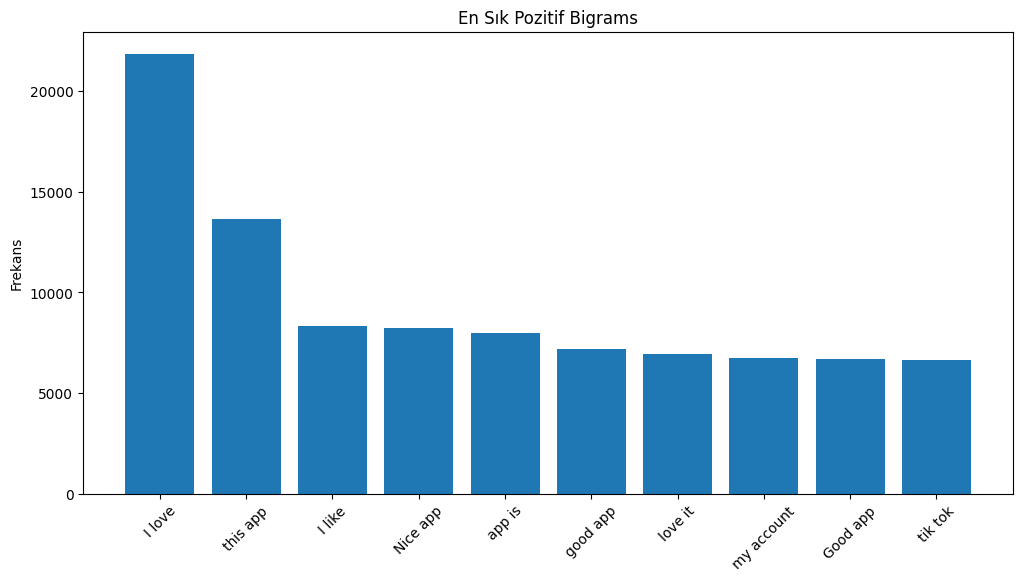

In [29]:
# Pozitif bigramların görselleştirilmesi
positive_bigram_labels, positive_bigram_counts = zip(*positive_bigram_freq)
plt.figure(figsize=(12, 6))
plt.bar([' '.join(bigram) for bigram in positive_bigram_labels], positive_bigram_counts)
plt.title('En Sık Pozitif Bigrams')
plt.xticks(rotation=45)
plt.ylabel('Frekans')
plt.show()

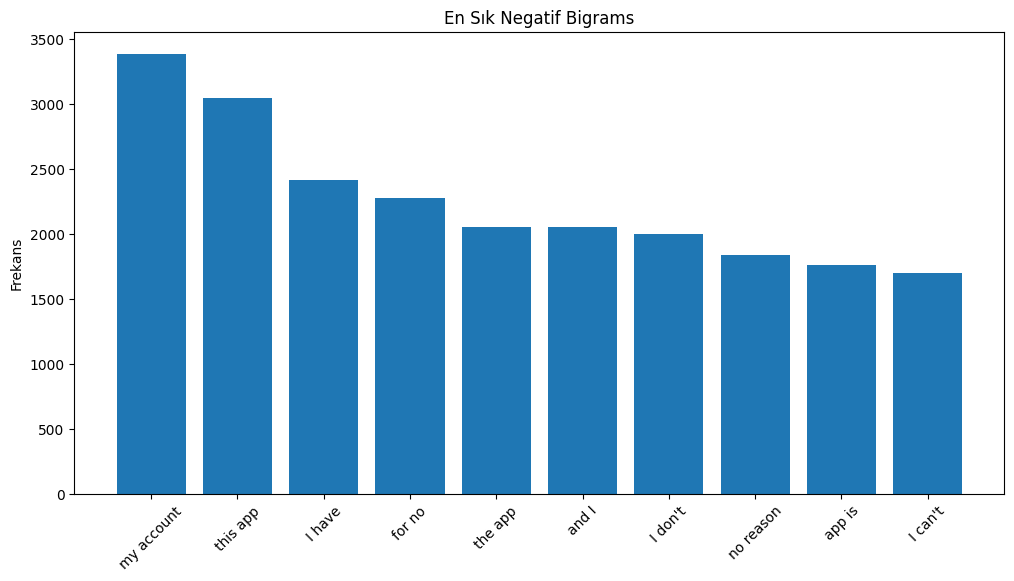

In [30]:
# Negatif bigramların görselleştirilmesi
negative_bigram_labels, negative_bigram_counts = zip(*negative_bigram_freq)
plt.figure(figsize=(12, 6))
plt.bar([' '.join(bigram) for bigram in negative_bigram_labels], negative_bigram_counts)
plt.title('En Sık Negatif Bigrams')
plt.xticks(rotation=45)
plt.ylabel('Frekans')
plt.show()

TikTok uygulamasıyla ilgili kullanıcı yorumlarını analiz ederek duygu durumlarını belirlemek için doğal dil işleme teknikleri kullanıldı. Pozitif bigramlar, kullanıcıların uygulamanın kalitesini ve keyfini vurgularken, sıkça görülen ifadeler "good app" ve "love app" gibi olumlu değerlendirmeleri içerdi. Negatif bigramlar ise, "ban" ve "account" gibi kelimelerle birlikte hesap yasakları ve olumsuz deneyimlere işaret etti. Genel olarak, kullanıcı memnuniyeti yüksek görünse de, hesap yasakları gibi problemler, olumsuz duyguları tetikleyerek kullanıcı deneyimini olumsuz etkiliyor. Sonuç olarak, uygulama geliştiricilerinin bu sorunlara odaklanarak kullanıcı geri bildirimlerini dikkate alması, kullanıcı memnuniyetini artırmak için kritik öneme sahiptir.